In [1]:
#%matplotlib notebook
import os
import numpy as np;
import matplotlib.pyplot as plt
from scipy import misc
import seaborn as sns
from RL_utils import *
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from itertools import combinations 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
import ptitprince as pt
import pandas as pd

Using TensorFlow backend.
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\py

Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
'''@misc{guest2017gini,
  author = "Olivia Guest",
  title = "Using the Gini Coefficient to Evaluate Deep Neural Network Layer Representations",
  year = "2017",
  howpublished = "Blog post",
  url = "http://neuroplausible.com/gini"
}'''
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    #array = np.abs(array)# change from original code
    #if np.amin(array) < 0:
     #   array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def gini2D(array):
    allG = []
    for v in array:
        allG.append(gini(v))
    return np.array(allG)

In [120]:
path = "./Results/TowerTraining/Recordings/Standard/3999_16.100/"
obs = np.load(path+"visobs.npy")
hand_l = pd.read_csv(path+'HandLabels.csv')
label_test = np.zeros(obs.shape[0])
label_test = np.array(hand_l['Label'])
def addLabel(currL,ToAdd):
    if ToAdd<=1:
        return currL
    elif ToAdd==2:
        currL[0] = 4
    elif ToAdd==3:
        currL[0] = 2
    elif ToAdd==4:
        currL[0] = 3
    elif ToAdd==5:
        currL[0] = 4
    elif ToAdd==6:
        currL[0]=1
    elif ToAdd==7:
        currL[1]=1
    elif ToAdd==8:
        currL[2]=1
    elif ToAdd==9:
        currL[3]=1
    else:
        print(ToAdd)
    return currL

def formatLabels(labels1,labels2):
    formatted = []
    for i,l in enumerate(labels1):
        newLabel=[0,0,0,0]
        if l == 0:
            print(i)
        newLabel = addLabel(newLabel,l)
        #print(str(i)+': '+str(newLabel)+ '  '+str(l))
        newLabel = addLabel(newLabel,labels2[i])
        #print(str(i)+': '+str(newLabel)+ '  '+str(labels2[i]))
        formatted.append(newLabel)
    return np.array(formatted)

fLabels = formatLabels(np.array(hand_l['Label']),np.array(hand_l['Secondary label']))

In [121]:
all_classes = ['[0, 0, 0, 0]','[0, 0, 0, 1]','[0, 0, 1, 0]','[0, 1, 0, 0]','[0, 1, 1, 0]','[1, 0, 0, 0]',
               '[1, 0, 1, 0]','[2, 0, 0, 0]','[2, 0, 0, 1]','[2, 0, 1, 0]','[2, 1, 0, 0]',#'[2, 1, 1, 0]','[2,0,1,1]'
               '[3, 0, 0, 0]','[3, 0, 0, 1]','[3, 0, 1, 0]','[3, 1, 0, 0]','[4, 0, 0, 0]','[4, 0, 0, 1]',
               '[4, 0, 1, 0]']
datagen = ImageDataGenerator(validation_split=0.1,rescale=1./255)
train_it = datagen.flow_from_directory('./Results/TowerTraining/Classifier/Sorted/', class_mode='sparse',
                                       batch_size=256,shuffle=True,subset="training",target_size=(168,168),classes=all_classes)
val_it = datagen.flow_from_directory('./Results/TowerTraining/Classifier/Sorted/', class_mode='sparse',
                                       batch_size=256,shuffle=True,subset="validation",target_size=(168,168),classes=all_classes)

realLabel = []
for c,v in train_it.class_indices.items():
    c_ext = np.fromstring(c[1:-1], dtype=int, sep=', ')
    realLabel.append(c_ext)

def getRealLabel(labelBatch,RL):
    newLB = []
    for label in labelBatch:
        l = RL[int(label)]
        newLB.append(l)
    return newLB

Found 34990 images belonging to 18 classes.
Found 3879 images belonging to 18 classes.


In [122]:
num_exp = [[0,0,0,0,0],[0,0],[0,0],[0,0]]
classes = [[[0,1,2,3,4],[5,6],[7,8,9,10],[11,12,13,14],[15,16,17]],[[0,1,2,5,6,7,8,9,11,12,13,15,16,17],[3,4,10,14]],
           [[0,1,3,5,7,8,10,11,12,14,15,16],[2,4,6,9,13,17]],[[0,2,3,4,5,6,7,9,10,11,13,14,15,17],[1,8,12,16]]]
for branch in range(len(num_exp)):
    for c in range(len(num_exp[branch])):
        sum_exp = 0
        for s in classes[branch][c]:
            sum_exp = sum_exp + train_it.classes[train_it.classes==s].shape[0]
        num_exp[branch][c] = sum_exp
print('Number of samples: '+str(num_exp))
if np.sum(num_exp[0])== np.sum(num_exp[1]) == np.sum(num_exp[2]) == np.sum(num_exp[3]):
    print('all good')

Number of samples: [[14656, 1426, 12153, 3892, 2863], [32770, 2220], [32277, 2713], [33195, 1795]]
all good


In [123]:
class_weights = [[0,0,0,0,0],[0,0],[0,0],[0,0]]
print('Class Weights: ')
for branch in range(len(class_weights)):
    bincount = np.array(num_exp[branch])
    weights = np.sum(bincount) / (bincount.shape[0] * bincount)
    class_weights[branch] = weights
    print(np.round(weights,2))


Class Weights: 
[0.48 4.91 0.58 1.8  2.44]
[0.53 7.88]
[0.54 6.45]
[0.53 9.75]


In [124]:
PATH_REL_META = './Results/TowerTraining/models/TowerF4/TowerF4_Baseline_Tests-0/LearningBrain/model-0.cptk.meta'
#PATH_REL_META = './Results/TowerTraining/Recordings/Standard/gradients/model-0.cptk.meta'
#PATH_REL_META = './Results/TowerTraining/Recordings/Standard/gradients/model-1000000.cptk.meta'
tf.reset_default_graph()
# start tensorflow session
with tf.Session() as sess:
    
    # import graph
    saver = tf.train.import_meta_graph(PATH_REL_META)
    
    
        
    # get all global variables (including model variables)
    vars_global = tf.global_variables()
    
    # get their name and value and put them into dictionary
    sess.as_default()
    init = tf.global_variables_initializer()
    sess.run(init)
    # load weights for graph
    saver.restore(sess, PATH_REL_META[:-5])
    model_vars = {}
    for var in vars_global:
        try:
            model_vars[var.name] = var.eval()
        except:
            print("For var={}, an exception occurred".format(var.name))
            
w0_0 = model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/kernel:0']

INFO:tensorflow:Restoring parameters from ./Results/TowerTraining/models/TowerF4/TowerF4_Baseline_Tests-0/LearningBrain/model-0.cptk


In [145]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
vec_obs_size = 8
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,4], dtype=tf.int64,name="labels")

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        #hidden_vec = observation_input
        #for i in range(num_layers):
        #    hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
        fc1 = tf.layers.dense(observation_input, h_size, activation=activation, reuse=reuse,name="hidden_0",
                              kernel_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/kernel:0']),
                             bias_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/bias:0']))
        hidden_vec = tf.layers.dense(fc1, h_size, activation=activation, reuse=reuse,name="hidden_1",kernel_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/kernel:0']),
                             bias_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/bias:0']))
        
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        #conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu,
                                 reuse=reuse,kernel_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/conv_1/kernel:0']), 
                                 bias_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/conv_1/bias:0']),name="conv_1")
        
        #conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse,kernel_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/conv_2/kernel:0']), 
                                 bias_initializer=tf.constant_initializer(model_vars['main_graph_0_encoder0/conv_2/bias:0']), name="conv_2")
        
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

def create_discrete_action_masking_layer(all_logits, action_size):
        """
        Creates a masking layer for the discrete actions
        :param all_logits: The concatenated unnormalized action probabilities for all branches
        :param action_size: A list containing the number of possible actions for each branch
        :return: The action output dimension [batch_size, num_branches] and the concatenated normalized logits
        """
        action_idx = [0] + list(np.cumsum(action_size))
        branches_logits = [all_logits[:, action_idx[i]:action_idx[i + 1]] for i in range(len(action_size))]#split in action branches (size=action_size)
        raw_probs = [tf.nn.softmax(branches_logits[k]) + 1.0e-10 for k in range(len(action_size))]
        normalized_probs = [
            tf.divide(raw_probs[k], tf.reduce_sum(raw_probs[k], axis=1, keepdims=True))
            for k in range(len(action_size))]
        #normalized_probs = raw_probs
        output = tf.concat([tf.multinomial(tf.log(normalized_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        #output = tf.concat([tf.multinomial(tf.nn.log_softmax(raw_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        
        log_probs = [tf.log(normalized_probs[k] + 1.0e-10) for k in range(len(action_size))]#xx
        log_probs_flat = tf.concat(log_probs, axis=1)
        return output, log_probs_flat, log_probs

visual_encoders = []

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden_visual = tf.concat(visual_encoders, axis=1)


class_size = [5,2,2,2]
policy_branches = []
for size in class_size:
    policy_branches.append(tf.layers.dense(hidden_visual, size, activation=None, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))
    #policy_branches.append(tf.layers.dense(hidden_visual, size, activation=tf.nn.relu, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))

all_log_probs = tf.concat([branch for branch in policy_branches], axis=1, name="action_probs")

output, normalized_logits_flat, norm_logits = create_discrete_action_masking_layer(all_log_probs, class_size)

output = tf.identity(output)
normalized_logits = tf.identity(normalized_logits_flat, name='action')#has nan in places where prob is negative bc it it log(probs)

comparison = tf.equal(labels, output)

accuracy = tf.reduce_mean(tf.cast(comparison, dtype=tf.float32))

cross_entropiesD = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[0], labels = labels[:,0])
cross_entropiesK = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[1], labels = labels[:,1])
cross_entropiesO = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[2], labels = labels[:,2])
cross_entropiesP = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[3], labels = labels[:,3])
print(cross_entropiesD)

class_weightsD = tf.constant(class_weights[0],dtype='float32')
class_weightsK = tf.constant(class_weights[1],dtype='float32')
class_weightsO = tf.constant(class_weights[2],dtype='float32')
class_weightsP = tf.constant(class_weights[3],dtype='float32')
print(class_weightsD)

weightsD = tf.reduce_sum(class_weightsD * tf.one_hot(labels[:,0],5), axis=1)
weightsK = tf.reduce_sum(class_weightsK * tf.one_hot(labels[:,1],2), axis=1)
weightsO = tf.reduce_sum(class_weightsO * tf.one_hot(labels[:,2],2), axis=1)
weightsP = tf.reduce_sum(class_weightsP * tf.one_hot(labels[:,3],2), axis=1)
print(weightsD)
scaled_errorD = cross_entropiesD * weightsD
scaled_errorK = cross_entropiesK * weightsK
scaled_errorO = cross_entropiesO * weightsO
scaled_errorP = cross_entropiesP * weightsP

cross_entropies = tf.reduce_mean([cross_entropiesD,cross_entropiesK,cross_entropiesO,cross_entropiesP],axis=1)
print(cross_entropies)
scaled_error = tf.reduce_mean([scaled_errorD,scaled_errorK,scaled_errorO,scaled_errorP],axis=1)

mean_cross_entropy = tf.reduce_mean(cross_entropies)
mean_scaled_error = tf.reduce_mean(scaled_error)

optimizer = tf.train.AdamOptimizer(0.0001)

gradients = optimizer.compute_gradients(mean_scaled_error)
hidden_grad = tf.gradients(mean_scaled_error,hidden_visual)

training_step = optimizer.minimize(mean_scaled_error)

saver = tf.train.Saver()

Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
Tensor("Const_1:0", shape=(5,), dtype=float32)
Tensor("Sum_4:0", shape=(?,), dtype=float32)
Tensor("Mean_1:0", shape=(4,), dtype=float32)


In [148]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Allentropies = []
Allaccuracies = []
Allscaled_errs = []
AllValaccuracies = []
AllGinis = []
LastSave = 0

print('            Entropy    Error   Accuracy')
epochs = 300
for i in range(epochs):
    count = 0
    xVal,yVal = val_it.next()
    yVal = getRealLabel(yVal,realLabel)
    Valentro, Valsc_err, Valaccu,Valcomp,Valout,ValProbs = sess.run([mean_cross_entropy, mean_scaled_error,accuracy, comparison,output,normalized_logits_flat], feed_dict = {visual_in: xVal, labels: yVal})

    if i==0:
        print('Validation:  '+str(Valentro)+ ' - '+str(Valsc_err)+' - '+str(Valaccu))
        AllValaccuracies.append(Valaccu)
    else:
        print('Training: '+str(np.mean(entropies))+' - '+str(np.mean(scaled_errs))+' - '+str(np.mean(accuracies))+
          '    Validation:  '+str(Valentro)+ ' - '+str(Valsc_err)+' - '+str(Valaccu))
    
    Testentro, Testsc_err, Testaccu,TestEnc = sess.run([mean_cross_entropy, mean_scaled_error,accuracy, encoded_visual], feed_dict = {visual_in: obs, labels: fLabels})
    print('Test:  '+str(Testentro)+ ' - '+str(Testsc_err)+' - '+str(Testaccu)+ ' - Gini: ' + str(np.round(gini(np.abs(TestEnc)),3)))
    AllGinis.append(gini(np.abs(TestEnc)))
    
    if Valaccu >np.max(AllValaccuracies):
        saver.save(sess, "./Results/TowerTraining/Classifier/Model_lr0001_scaled/model.ckpt")
        print('saved model')
        LastSave = i-1
        
    AllValaccuracies.append(Valaccu)
    for batchX, batchy in train_it:
        batchy = getRealLabel(batchy,realLabel)
        entropies = []
        accuracies = []
        scaled_errs = []
        entro, sc_err, accu,comp, _ = sess.run([mean_cross_entropy, mean_scaled_error,accuracy, comparison,training_step], feed_dict = {visual_in: batchX, labels: batchy})
        entropies.append(entro)
        accuracies.append(accu)
        scaled_errs.append(sc_err)
        #print(str(entro)+' - '+str(accu))
        if count>126:
            Allentropies.append(entropies)
            Allaccuracies.append(accuracies)
            Allscaled_errs.append(scaled_errs)
            break
        count = count+1
    

            Entropy    Error   Accuracy
Validation:  0.9223487 - 0.9455937 - 0.41308594
Test:  0.9221959 - 1.1352395 - 0.419375 - Gini: 0.427
Training: 0.8313726 - 0.8660714 - 0.49121094    Validation:  0.8559714 - 0.86934936 - 0.47558594
Test:  0.88008356 - 1.0652106 - 0.45875 - Gini: 0.556
saved model
Training: 0.68972087 - 0.7662134 - 0.56152344    Validation:  0.7154081 - 0.77781177 - 0.5527344
Test:  0.7736244 - 0.8833164 - 0.52425 - Gini: 0.53
saved model
Training: 0.6810932 - 0.673002 - 0.5625    Validation:  0.795979 - 0.7836481 - 0.53515625
Test:  0.84895545 - 0.8109192 - 0.520625 - Gini: 0.494
Training: 0.7080605 - 0.59155977 - 0.57128906    Validation:  0.7154766 - 0.65020984 - 0.56152344
Test:  0.8088355 - 0.78989416 - 0.563125 - Gini: 0.485
saved model
Training: 0.510458 - 0.4892693 - 0.6591797    Validation:  0.5544194 - 0.6074956 - 0.6455078
Test:  0.70165205 - 0.9287156 - 0.6044375 - Gini: 0.501
saved model
Training: 0.5476562 - 0.55426216 - 0.65527344    Validation:  0

Test:  0.85362506 - 2.9397821 - 0.8323125 - Gini: 0.552
Training: 0.027524501 - 0.016032204 - 0.9814453    Validation:  0.32665777 - 1.2556105 - 0.92578125
Test:  0.76220727 - 2.6079438 - 0.848 - Gini: 0.557
saved model
Training: 0.025891729 - 0.018437695 - 0.984375    Validation:  0.3646149 - 1.0459586 - 0.9199219
Test:  0.7504942 - 2.3097644 - 0.8484375 - Gini: 0.55
Training: 0.019859266 - 0.013477181 - 0.9873047    Validation:  0.39952314 - 1.4212087 - 0.9121094
Test:  0.7969402 - 2.8525014 - 0.8505 - Gini: 0.544
Training: 0.015879937 - 0.010758436 - 0.9902344    Validation:  0.38292035 - 1.6081402 - 0.9316406
Test:  0.76545775 - 2.462642 - 0.8549375 - Gini: 0.541
saved model
Training: 0.021215394 - 0.012426771 - 0.9863281    Validation:  0.49882016 - 2.4240222 - 0.8717949
Test:  0.82957745 - 2.7786226 - 0.847125 - Gini: 0.542
Training: 0.014798776 - 0.010280924 - 0.9863281    Validation:  0.41494888 - 1.4183373 - 0.9160156
Test:  0.8356049 - 3.0094967 - 0.8523125 - Gini: 0.539
Trai

Test:  1.1263155 - 3.6807866 - 0.858 - Gini: 0.552
Training: 0.00052308367 - 0.0003793439 - 1.0    Validation:  0.53565323 - 1.8319653 - 0.93359375
Test:  1.130632 - 3.6015837 - 0.855375 - Gini: 0.553
Training: 0.0021540336 - 0.0011636384 - 1.0    Validation:  0.6221508 - 2.4626017 - 0.9189453
Test:  1.1409837 - 3.640598 - 0.8545 - Gini: 0.552
Training: 0.008414131 - 0.004328823 - 0.9970703    Validation:  0.6214091 - 1.9956819 - 0.9140625
Test:  1.0956078 - 3.605227 - 0.859625 - Gini: 0.555
Training: 0.0016289952 - 0.00092081976 - 0.99902344    Validation:  0.64874303 - 1.9525859 - 0.9111328
Test:  1.1525097 - 3.6509454 - 0.8540625 - Gini: 0.552
Training: 0.014491842 - 0.008430833 - 0.9921875    Validation:  0.5105573 - 1.868795 - 0.9169922
Test:  1.2225013 - 3.4122548 - 0.8415625 - Gini: 0.576
Training: 0.033131637 - 0.020390738 - 0.9814453    Validation:  0.6092027 - 1.7852123 - 0.90527344
Test:  1.2234789 - 2.536708 - 0.8329375 - Gini: 0.59
Training: 0.016812494 - 0.009600925 - 0.9

Test:  1.2141614 - 3.8735151 - 0.8554375 - Gini: 0.594
Training: 0.0005651682 - 0.00046679453 - 0.99902344    Validation:  0.6020152 - 2.1921713 - 0.93359375
Test:  1.2166677 - 3.786564 - 0.8546875 - Gini: 0.592
Training: 0.0011538473 - 0.0006745354 - 0.99902344    Validation:  0.61201376 - 2.3834736 - 0.9316406
Test:  1.2238945 - 3.7674794 - 0.8548125 - Gini: 0.59
Training: 0.00031629598 - 0.00019916544 - 1.0    Validation:  0.5505862 - 1.7282435 - 0.9316406
Test:  1.2213079 - 3.810803 - 0.85475 - Gini: 0.587
Training: 0.0004732063 - 0.00033341022 - 1.0    Validation:  0.7048188 - 2.3663588 - 0.91796875
Test:  1.2588465 - 3.9872243 - 0.854375 - Gini: 0.585
Training: 0.00045985729 - 0.0002928074 - 1.0    Validation:  0.5309609 - 1.8485171 - 0.9248047
Test:  1.2496017 - 3.9014096 - 0.855 - Gini: 0.582
Training: 0.0020378206 - 0.0013063689 - 0.99902344    Validation:  0.54163086 - 1.885817 - 0.9189453
Test:  1.2306201 - 3.8619509 - 0.8566875 - Gini: 0.582
Training: 0.0008028868 - 0.00051

Test:  1.2718055 - 3.9077277 - 0.8546875 - Gini: 0.613
Training: 0.0033337034 - 0.0019274431 - 0.9980469    Validation:  0.65773475 - 2.3987381 - 0.92578125
Test:  1.2695737 - 3.8371096 - 0.8529375 - Gini: 0.617
Training: 0.0009326328 - 0.0006197545 - 1.0    Validation:  0.5549389 - 1.2863393 - 0.92285156
Test:  1.2601308 - 3.7902806 - 0.857375 - Gini: 0.613
Training: 0.0015847806 - 0.00089379173 - 0.99902344    Validation:  0.4919615 - 1.6580806 - 0.9238281
Test:  1.248448 - 3.766694 - 0.85775 - Gini: 0.609
Training: 0.00033455016 - 0.0002445943 - 0.9980469    Validation:  1.0289742 - 4.1857076 - 0.89102566
Test:  1.286295 - 3.9221673 - 0.8553125 - Gini: 0.605
Training: 0.022017954 - 0.012072794 - 0.99902344    Validation:  0.63414574 - 2.3168983 - 0.92285156
Test:  1.2780019 - 3.9399424 - 0.858875 - Gini: 0.603
Training: 0.00029016327 - 0.00022443803 - 1.0    Validation:  0.81440556 - 2.730659 - 0.91503906
Test:  1.274299 - 3.9233766 - 0.857875 - Gini: 0.602
Training: 0.0001881976 - 

Test:  1.3413543 - 4.3161364 - 0.859375 - Gini: 0.602
Training: 7.088627e-05 - 6.604395e-05 - 1.0    Validation:  0.79967576 - 2.9747224 - 0.9140625
Test:  1.380301 - 4.3462954 - 0.856875 - Gini: 0.602
Training: 5.900969e-05 - 4.845614e-05 - 1.0    Validation:  0.6533303 - 1.6655931 - 0.9160156
Test:  1.3893273 - 4.3489237 - 0.856625 - Gini: 0.601
Training: 9.762803e-05 - 7.860636e-05 - 1.0    Validation:  0.6578852 - 2.869558 - 0.9267578
Test:  1.3226573 - 4.2536125 - 0.86225 - Gini: 0.603
Training: 7.3219664e-05 - 4.727416e-05 - 1.0    Validation:  0.574523 - 1.4532623 - 0.921875
Test:  1.3666542 - 4.3551493 - 0.8585 - Gini: 0.6
Training: 0.00015623607 - 0.00010256646 - 1.0    Validation:  0.60611725 - 1.8314981 - 0.9296875
Test:  1.3894067 - 4.4884095 - 0.85825 - Gini: 0.589
Training: 0.00013797096 - 8.660879e-05 - 1.0    Validation:  0.6494351 - 2.5654235 - 0.9355469
Test:  1.3916564 - 4.3414297 - 0.8558125 - Gini: 0.594
Training: 6.303105e-05 - 5.102885e-05 - 1.0    Validation:  0

In [152]:
np.where(AllValaccuracies==np.max(AllValaccuracies))

(array([154], dtype=int64),)

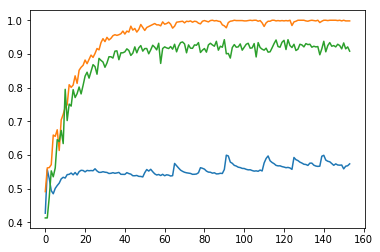

In [157]:
plt.plot(AllGinis[:154])
plt.plot(Allaccuracies[:154])
plt.plot(AllValaccuracies[:154])
plt.show()

In [13]:
import os
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
from keras import backend as k
from keras.models import Sequential,Model
from keras.layers.convolutional import Conv3D, Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,MaxPooling2D,TimeDistributed,Input,concatenate,Flatten,Reshape,LSTM,Lambda
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
from keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    directory='C:/Users/vkakerbeck/Dropbox/PhD/Data/ObstacleTower/',
    target_size=(168, 168),
    color_mode="rgb",
    batch_size=256,
    class_mode="input",
    shuffle=True,
    seed=42
)

Found 100195 images belonging to 1 classes.


In [188]:
from keras import backend as K
K.clear_session()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

inImg = Input(batch_shape=(None,168, 168, 3),name="input_1")
#conv1 = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="conv_1")(inImg)
conv1 = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu,weights=[model_vars['main_graph_0_encoder0/conv_1/kernel:0'],model_vars['main_graph_0_encoder0/conv_1/bias:0']], name="conv_1")(inImg)
print(conv1)
#conv2 = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="conv_2")(conv1)
conv2 = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu,weights=[model_vars['main_graph_0_encoder0/conv_2/kernel:0'],model_vars['main_graph_0_encoder0/conv_2/bias:0']], name="conv_2")(conv1)
print(conv2)
flat = Reshape((19*19*32,))(conv2)#Flatten()(conv)
print(flat)
#dens = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_1")(flat)
dens = Dense(256,activation=swish,weights=[model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/kernel:0'],model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/bias:0']], name="dens_1")(flat)
print(dens)
#enc = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_2")(dens)
enc = Dense(256,activation=swish,weights=[model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/kernel:0'],model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/bias:0']], name="dens_2")(dens)
print(enc)
de_dens = Dense(20*20*32,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_3")(enc)
print(de_dens)
shaped = Reshape((20, 20, 32))(de_dens)
print(shaped)
de_conv = Conv2DTranspose(filters=16, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="deconv_1")(shaped)
print(de_conv)
#de_conv = Conv2DTranspose(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="deconv_2")(de_conv)
#print(de_conv)
prediction = Conv2DTranspose(filters=3, kernel_size=[8, 8], strides=[4, 4],padding='same',activation=tf.nn.elu, name="deconv_3")(de_conv)
print(prediction)
model = Model(inputs=inImg, outputs=prediction)

#model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy','loss'])
#model.compile(optimizer='adadelta',loss='mean_squared_error',metrics=['accuracy','mse'])
optimizer = tf.train.AdamOptimizer(0.0001)

model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['accuracy','mse'])

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.get_layer('dens_2').output,model.get_layer('deconv_3').output])


Tensor("conv_1/Elu:0", shape=(?, 41, 41, 16), dtype=float32)
Tensor("conv_2/Elu:0", shape=(?, 19, 19, 32), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 11552), dtype=float32)
Tensor("dens_1/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_2/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_3/Mul:0", shape=(?, 12800), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(?, 20, 20, 32), dtype=float32)
Tensor("deconv_1/Elu:0", shape=(?, ?, ?, 16), dtype=float32)
Tensor("deconv_3/Elu:0", shape=(?, ?, ?, 3), dtype=float32)


In [189]:
GinisAE = []
LossesAE = []
AccAE = []
actAE,_ = intermediate_layer_model.predict(obs)
giniI = gini(np.abs(actAE))
print('Gini: '+str(np.round(giniI,3)))
GinisAE.append(giniI)

for e in range(50):
    info = model.fit_generator(train_generator,epochs=1)
    LossesAE.append(info.history['loss'])
    AccAE.append(info.history['acc'])
    actAE,_ = intermediate_layer_model.predict(obs)
    giniI = gini(np.abs(actAE))
    print('Gini: '+str(np.round(giniI,3)))
    GinisAE.append(giniI)

Gini: 0.427
Epoch 1/1
392/392 [==============================] - 2519s 6s/step - loss: 0.0182 - acc: 0.5511 - mean_squared_error: 0.0182
Gini: 0.468
Epoch 1/1
392/392 [==============================] - 2135s 5s/step - loss: 0.0076 - acc: 0.6861 - mean_squared_error: 0.0076
Gini: 0.44
Epoch 1/1
392/392 [==============================] - 1853s 5s/step - loss: 0.0064 - acc: 0.7261 - mean_squared_error: 0.0064
Gini: 0.407
Epoch 1/1
392/392 [==============================] - 1881s 5s/step - loss: 0.0058 - acc: 0.7482 - mean_squared_error: 0.0058
Gini: 0.376
Epoch 1/1
392/392 [==============================] - 1825s 5s/step - loss: 0.0054 - acc: 0.7610 - mean_squared_error: 0.0054
Gini: 0.35
Epoch 1/1
392/392 [==============================] - 1657s 4s/step - loss: 0.0052 - acc: 0.7715 - mean_squared_error: 0.0052
Gini: 0.332
Epoch 1/1
392/392 [==============================] - 1428s 4s/step - loss: 0.0050 - acc: 0.7808 - mean_squared_error: 0.0050
Gini: 0.318
Epoch 1/1
392/392 [============

In [196]:
model.save_weights(path+'autoencoder/aemodelAdam50E.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


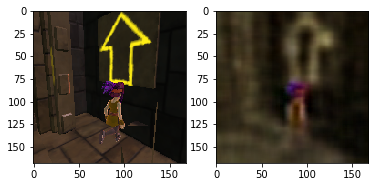

In [197]:
i=60
out = model.predict(obs[i].reshape((1,168,168,3)))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(obs[i])
plt.subplot(1,2,2)
plt.imshow(out[0])
plt.show()

In [199]:
intermediate_output = intermediate_layer_model.predict(obs)

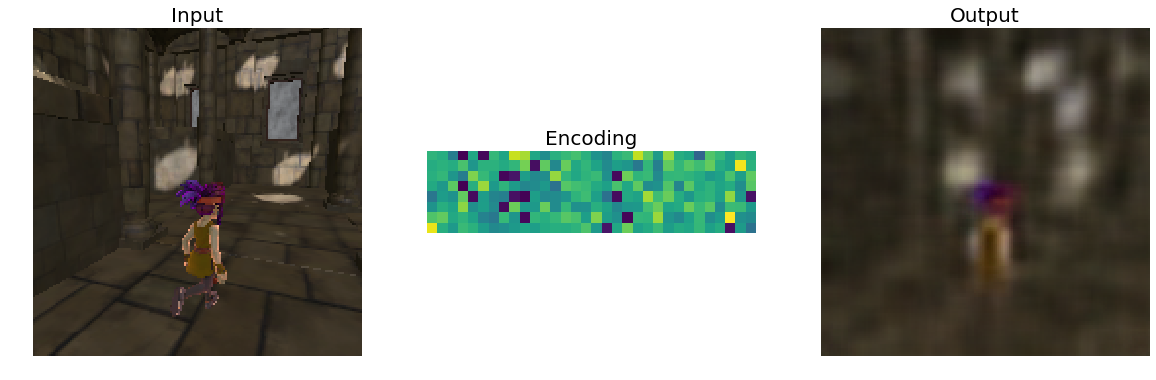

In [200]:
i=705
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.imshow(obs[i])
plt.title('Input',fontsize=20)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(intermediate_output[0][i].reshape((8,32)))
plt.title('Encoding',fontsize=20)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(intermediate_output[1][i])
plt.title('Output',fontsize=20)
plt.axis('off')
plt.show()
#plt.savefig(path+'autoencoder/Example3.png', bbox_inches='tight')

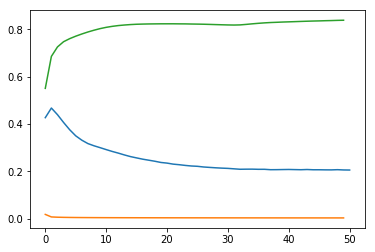

In [195]:
plt.plot(GinisAE)
plt.plot(LossesAE)
plt.plot(AccAE)

In [50]:
savepath = './Results/TowerTraining/Recordings/Standard/gradients/runVars/'
np.save(savepath+'ginisAE.npy',np.array(GinisAE))
np.save(savepath+'lossesAE.npy',np.array(LossesAE))
np.save(savepath+'accAE.npy',np.array(AccAE))
np.save(savepath+'lossesC.npy',np.array(SEC))
np.save(savepath+'ginisC.npy',np.array(AllGinis))
np.save(savepath+'accC.npy',np.array(Allaccuracies))
np.save(savepath+'entroC.npy',np.array(Allentropies))
np.save(savepath+'valAccC.npy',np.array(AllValaccuracies))

In [167]:
np.save("./Results/TowerTraining/Classifier/Model_lr0001_scaled/Accs.npy",Allaccuracies)
np.save("./Results/TowerTraining/Classifier/Model_lr0001_scaled/Entro.npy",Allentropies)
np.save("./Results/TowerTraining/Classifier/Model_lr0001_scaled/Err.npy",Allscaled_errs)
np.save("./Results/TowerTraining/Classifier/Model_lr0001_scaled/ValAcc.npy",AllValaccuracies)

In [209]:
ginisA = np.load(savepath+'ginisA.npy')
giniStepsA = np.load(savepath+'giniStepsA.npy')
ginisAL = np.load(savepath+'ginisEasyLong.npy')
giniStepsAL = np.load(savepath+'giniStepsEL.npy')
ginisC = np.load(savepath+'ginisC.npy')
valAccC = np.load(savepath+'valAccC.npy')

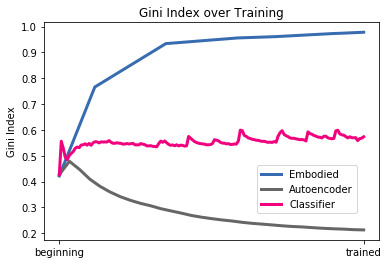

In [168]:
plt.figure()
CLastSave= np.where(valAccC==np.max(valAccC))[0][0]
plt.plot(giniStepsA*10,ginisA,color=sns.color_palette("Accent", n_colors=8)[4],lw=3)
plt.plot(np.linspace(0,300,31),GinisAE,color=sns.color_palette("Accent", n_colors=8)[7],lw=3)
plt.plot(np.linspace(0,300,CLastSave),ginisC[:CLastSave],color=sns.color_palette("Accent", n_colors=8)[5],lw=3)

plt.xticks([0,300],['beginning','trained'])
plt.ylabel('Gini Index')
plt.title('Gini Index over Training')
plt.legend(['Embodied','Autoencoder','Classifier'],loc=4, bbox_to_anchor=(0.95, 0.1))
#plt.show()
plt.savefig(figure_path+'GinisScale.eps', bbox_inches='tight', dpi=300)

In [202]:
print('Classifier saw '+str(CLastSave*126*256)+' images')
print('Autoencoder saw '+str(256*392*50)+' images')
print('Agent saw 30.100.000 images')

Classifier saw 4967424 images
Autoencoder saw 5017600 images
Agent saw 30.100.000 images


In [205]:
giniStepsAL

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  80.,
        85.,  90.,  95., 100., 105., 110., 115., 120., 125., 130., 135.,
       140., 145., 150., 155., 160., 165., 170., 175., 180., 185., 190.,
       195., 200., 205., 210., 215., 220., 225., 230., 235., 240., 245.,
       250., 255., 260., 265., 270., 275., 280., 285., 290., 295., 300.])

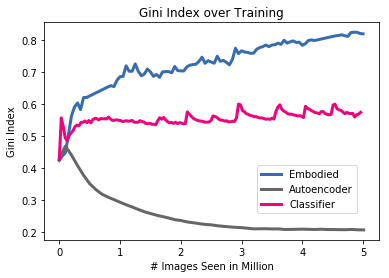

In [210]:
figure_path = './Results/TowerTraining/Figures/NNFiguresSameOpt/'
plt.figure()
plt.plot(giniStepsAL,ginisAL,color=sns.color_palette("Accent", n_colors=8)[4],lw=3)
plt.plot(np.linspace(0,501,51),GinisAE,color=sns.color_palette("Accent", n_colors=8)[7],lw=3)
plt.plot(np.linspace(0,496,CLastSave),ginisC[:CLastSave],color=sns.color_palette("Accent", n_colors=8)[5],lw=3)

plt.xticks([0,100,200,300,400,500],['0','1','2','3','4','5'])
plt.xlabel('# Images Seen in Million')
plt.ylabel('Gini Index')
plt.title('Gini Index over Training')
plt.legend(['Embodied','Autoencoder','Classifier'],loc=4, bbox_to_anchor=(0.95, 0.1))
#plt.show()
plt.savefig(figure_path+'Ginis.eps', bbox_inches='tight', dpi=300)